<a href="https://colab.research.google.com/github/vap326/cse337/blob/main/lab10_half_cheetah_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# HalfCheetah: Learn a Dynamics Model from Random Rollouts (Then Validate It)

**Goal:** In this notebook you'll (1) collect random experience tuples \((s_t, a_t, r_t, s_{t+1})\) from `HalfCheetah-v4`, (2) train a neural network to predict **state deltas** \(\Delta s = s_{t+1}-s_t\), and (3) **validate** the model with one-step and multi-step (open-loop) rollouts.

This mirrors the first phase of model-based control (e.g., MPPI): learn a model offline, then use it for planning.



## 0. Requirements

- Python 3.9+
- PyTorch `>= 1.10`
- Gymnasium `>= 0.29`
- MuJoCo with `HalfCheetah-v4` (install `mujoco` and `gymnasium[mujoco]`)

```bash
pip install "gymnasium[mujoco]" mujoco torch matplotlib
```

**Try and understand what RunningNormalizer does.**


In [4]:
pip install "gymnasium[mujoco]" mujoco torch matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 19.0 MB/s eta 0:00:00


In [5]:

import os, math, random, time
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

def to_t(x):
    return th.as_tensor(x, dtype=th.float32)

def fanin_init(m):
    if isinstance(m, nn.Linear):
        bound = 1.0 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, +bound)
        nn.init.zeros_(m.bias)

class RunningNormalizer:
    """Feature-wise running mean/std (Welford)."""
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        self.count = 0
        self.mean = np.zeros(dim, dtype=np.float64)
        self.M2   = np.zeros(dim, dtype=np.float64)
        self.eps  = eps

    def update(self, x: np.ndarray):
        x = np.asarray(x)
        if x.ndim == 1: x = x[None, :]
        for v in x:
            self.count += 1
            d = v - self.mean
            self.mean += d / self.count
            d2 = v - self.mean
            self.M2 += d * d2

    @property
    def var(self):
        if self.count < 2: return np.ones(self.dim, dtype=np.float64)
        return self.M2 / (self.count - 1 + 1e-12)

    @property
    def std(self):
        return np.sqrt(self.var + self.eps)

    def normalize(self, x): return (x - self.mean) / self.std
    def denormalize(self, x): return x * self.std + self.mean

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); th.manual_seed(seed)



## Initializing Environment and Figure Out Observation Structure

`HalfCheetah-v4` exposes observations as `[qpos[1:], qvel[:]]`. The forward velocity is `qvel[0]`, which sits at index `len(qpos[1:])` inside the observation vector. We'll extract that index for later validation/plots. :::: This is important for planning, if we want to know what each state represents


In [11]:

set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_low = env.action_space.low
act_high = env.action_space.high

# Find start index of qvel inside obs = [qpos[1:], qvel[:]]
nq = env.unwrapped.model.nq
qvel_start = int(nq - 1)
print("obs_dim:", obs_dim, "act_dim:", act_dim, "qvel_start:", qvel_start)


obs_dim: 17 act_dim: 6 qvel_start: 8


## 🧩 Task 1: Prepare the Replay Buffer
**Goal:** Store transitions \((s_t, a_t, s_{t+1})\) and return training pairs \((x, y) = (s_t, a_t, s_{t+1} - s_t)\).

**Instructions:**
- Implement `add()` to record transitions.
- Add a `sample()` method to randomly sample batch of certain size.



In [15]:
# Create the class and create a class object
class Replay:
    def __init__(self, obs_dim, act_dim, capacity=300000):
        self.obs = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.act = np.zeros((capacity, act_dim), dtype=np.float32)
        self.nxt = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.rew = np.zeros((capacity, 1), dtype=np.float32)
        self.term = np.zeros((capacity, 1), dtype=np.float32)
        self.ptr = 0; self.size = 0; self.cap = capacity

    def add(self, s, a, r, sp, term):
        idx = self.ptr
        self.obs[idx] = np.asarray(s, dtype=np.float32)
        self.act[idx] = np.asarray(a, dtype=np.float32)
        self.nxt[idx] = np.asarray(sp, dtype=np.float32)
        # ensure reward and term stored as shape (1,)
        self.rew[idx] = np.asarray(r, dtype=np.float32).reshape(-1)[:1]
        self.term[idx] = np.asarray(term, dtype=np.float32).reshape(-1)[:1]
        # advance pointer and update size
        self.ptr = (self.ptr + 1) % self.cap
        self.size = min(self.size + 1, self.cap)

    def sample(self, batch):
        assert self.size > 0, "Replay buffer empty"
        idxs = np.random.randint(0, self.size, size=batch)
        # return copies to avoid accidental in-place modifications of the buffer
        return (self.obs[idxs].copy(),
                self.act[idxs].copy(),
                self.rew[idxs].copy(),
                self.nxt[idxs].copy(),
                self.term[idxs].copy())

replay = Replay(obs_dim, act_dim)



## Task 2. Collect Random Rollouts

- Gather random actions for a number of steps to create our training dataset. Collect data for 100000 steps.
- Call the function and fill the replay buffer


In [16]:

def collect_random(env, replay, steps=10000, seed=42):
    set_seed(seed) # reproducible action sampling (numpy & random)
    obs, _ = env.reset(seed=seed) # reset environment and get initial observation
    ep_len = 0
    for t in range(steps):
        a = env.action_space.sample()  # sample a uniform random action
        sp, r, term, trunc, info = env.step(a)  # step the env
        # store (s, a, r, s', done) into the buffer; convert done/trunc to float
        replay.add(obs, a, r, sp, float(term or trunc))
        obs = sp
        ep_len += 1
        # if episode ended or reached max_ep_len, reset environment
        if term or trunc or ep_len >= 1000:
            obs, _ = env.reset()
            ep_len = 0
    print(f"Collected {replay.size} transitions into replay (capacity {replay.cap}).")





## Task 3. Update normalizers from the collected random data in the replay buffer

We normalize inputs (`[s,a]`) and targets (`Δs = s' - s`) for stable training.


In [18]:
obs_norm = RunningNormalizer(obs_dim)
inp_norm = RunningNormalizer(obs_dim + act_dim)
targ_norm = RunningNormalizer(obs_dim)

# write the function to update the normalizers from the data collected in the buffer
def update_normalizers_from_buffer(replay):
    n = replay.size
    assert n > 0, "Replay buffer empty - collect data first."
    # Update obs normalizer with states s
    obs_norm.update(replay.obs[:n])
    # Build inputs [s, a] and update input normalizer
    inputs = np.concatenate([replay.obs[:n], replay.act[:n]], axis=1)
    inp_norm.update(inputs)
    # Compute deltas s' - s as targets and update target normalizer
    deltas = replay.nxt[:n] - replay.obs[:n]
    targ_norm.update(deltas)

collect_random(env, replay, steps=100000)
update_normalizers_from_buffer(replay)
print("Normalizers ready.")

Collected 100000 transitions into replay (capacity 300000).
Normalizers ready.



## Defining the Neural Dynamics Model

We predict **normalized** `Δs` from **normalized** `[s, a]`.
NN parameters:

- initialize a deterministic NN with a ExponentialLR sceduler( that decays the learning rate with epoch)
- width = 200, depth = 3, lr = 1e-3, weight_decay - 1e-5, gamma for scheduler = 0.8
- These are a starting point but not the best parameters.


In [19]:

class DetMLP(nn.Module):
    """Predicts Δstate deterministically."""
    def __init__(self, in_dim, out_dim, width=200, depth=3):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU()]
            last = width
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
        self.apply(fanin_init)

    def forward(self, x):
        return self.net(x)

in_dim = obs_dim + act_dim
out_dim = obs_dim
model = DetMLP(in_dim, out_dim, width=200, depth=3)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)



## Task 4. Train the Model

We minimize MSE between predicted normalized `Δs` and target normalized `Δs`.

- Train in batches, keep the batch size 256
- Use a learning rate scheduler that decays the learning rate as training progresses. You may use the pytorch utility. See how the learning rate decays with each epoch.
- Train for 30 epochs and plot the training curve. Loss vs epoch.
- Find the best parameters(defined in the previous block)



In [21]:

def train_model(model, replay, epochs=30, batch_size=256):
    model.to(device)
    mse = nn.MSELoss()
    losses = []
    # we will use a simple epoch definition: steps_per_epoch ~= size // batch_size
    steps_per_epoch = max(1, replay.size // batch_size)
    for epoch in range(epochs):
        model.train()
        epoch_losses = []
        for _ in range(steps_per_epoch):
            # sample a minibatch of raw transitions
            s, a, r, sp, term = replay.sample(batch_size)
            # build model inputs and targets
            x = np.concatenate([s, a], axis=1).astype(np.float32)  # [B, obs+act]
            y = (sp - s).astype(np.float32)                        # [B, obs] target deltas
            # normalize inputs and targets using precomputed normalizers
            x_n = inp_norm.normalize(x).astype(np.float32)
            y_n = targ_norm.normalize(y).astype(np.float32)

            x_t = to_t(x_n).to(device)
            y_t = to_t(y_n).to(device)

            pred = model(x_t)                 # predict normalized Δs
            loss = mse(pred, y_t)             # MSE in normalized space

            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_losses.append(loss.item())

        # scheduler step at the end of each epoch to decay LR
        scheduler.step()
        mean_loss = float(np.mean(epoch_losses))
        losses.append(mean_loss)
        print(f"[Epoch {len(losses):02d}/{epochs}] train_loss={mean_loss:.6f} lr={opt.param_groups[0]['lr']:.3e}")
    return losses

# losses = train_model(model, replay, epochs=10, batch_size=64)
# plt.figure()
# plt.plot(losses)
# plt.xlabel("Epoch")
# plt.ylabel("MSE (normalized Δs)")
# plt.title("Model Training Loss")
# plt.show()


## Task 5. Validate your model: One-Step and Multi-Step Prediction Error

- Evaluate your trained model on a held-out set of random transitions.
Generate a batch of unseen samples, predict the next-state delta, and compute the one-step MSE.

- Repeat with open-loop rollouts of length k.
Drive both the real environment and the model with the same action sequence, then report how prediction error grows across steps.

In [22]:

# your code here
def random_batch_from_env(env, N=5000, seed=999):
    set_seed(seed)
    obs, _ = env.reset(seed=seed)
    Xs, As, Ys = [], [], []
    i = 0
    while i < N:
        a = env.action_space.sample()
        sp, r, term, trunc, info = env.step(a)
        Xs.append(obs.copy())
        As.append(a.copy())
        Ys.append((sp - obs).copy())  # store delta directly
        obs = sp
        i += 1
        if term or trunc:
            obs, _ = env.reset()
    return np.array(Xs, dtype=np.float32), np.array(As, dtype=np.float32), np.array(Ys, dtype=np.float32)

def one_step_mse(model, inp_norm, targ_norm, env, N=2000):
    model.eval()
    s, a, y_true = random_batch_from_env(env, N=N)
    x = np.concatenate([s, a], axis=1).astype(np.float32)
    x_n = inp_norm.normalize(x).astype(np.float32)
    x_t = to_t(x_n).to(device)
    with th.no_grad():
        pred_n = model(x_t).cpu().numpy()  # predicted normalized delta
    pred = targ_norm.denormalize(pred_n)  # convert back to raw delta
    mse = np.mean((pred - y_true) ** 2)   # mean squared error across all state dims
    return mse

def multi_step_error(model, inp_norm, targ_norm, env, k=50, n_trajs=50, seed=0):
    set_seed(seed)
    per_step_err = np.zeros(k, dtype=np.float64)

    for traj in range(n_trajs):
        obs, _ = env.reset(seed=(seed + traj))  # different seed per trajectory
        s_model = obs.copy()                    # model's internal state estimate (starts at same initial obs)
        # pre-sample the same action sequence for real env and model
        actions = [env.action_space.sample() for _ in range(k)]

        real_states = [obs.copy()]
        model_states = [s_model.copy()]

        for t in range(k):
            a = actions[t]
            sp, r, term, trunc, info = env.step(a)  # real environment step
            real_states.append(sp.copy())

            # Model prediction step (open-loop):
            x = np.concatenate([s_model[None, :], np.array(a)[None, :]], axis=1).astype(np.float32)
            x_n = inp_norm.normalize(x).astype(np.float32)
            x_t = to_t(x_n).to(device)
            with th.no_grad():
                delta_n = model(x_t).cpu().numpy()    # normalized delta
            delta = targ_norm.denormalize(delta_n).reshape(-1)  # raw delta
            s_model = s_model + delta              # integrate predicted delta (s_{t+1} = s_t + Δs)
            model_states.append(s_model.copy())

            # squared error between model-predicted state and real next state
            err = np.mean((model_states[-1] - real_states[-1]) ** 2)
            per_step_err[t] += err

            if term or trunc:
                # environment episode ended early; break out and do not include further steps
                break

    per_step_err /= float(n_trajs)  # average across trajectories
    return per_step_err


## Task 6. Visualize Rollout Trajectories

**Setup**
Call model.eval() so gradients stay off.
Reset the env with the provided seed; keep a copy of the initial observation.


**Choose actions**
Pre-sample k actions from env.action_space.sample() so the real system and the model rollout see the same sequence.

**Roll forward**
For each action:
Step the real env (env.step(a)), append the new observation.
For the model path:
Build [s_model, a], normalize via inp_norm.normalize, turn into a tensor with to_t.
Run the network, de-normalize with targ_norm.denormalize, add to the last model state, append.
Stop early if the env terminates or truncates.

**Plot**
Plot the real trajectory as one line, model trajectory as another.



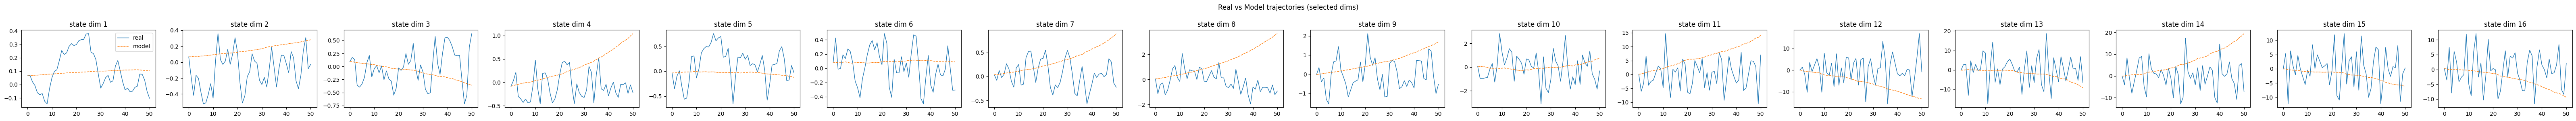

In [26]:

def visualize_rollout(env, model, k=50, dims=(0, 5, 10), seed=2025):
    model.eval()
    set_seed(seed)
    obs, _ = env.reset(seed=seed)
    s_model = obs.copy()
    actions = [env.action_space.sample() for _ in range(k)]
    real_traj = [obs.copy()]
    model_traj = [s_model.copy()]

    for t in range(k):
        a = actions[t]
        sp, r, term, trunc, info = env.step(a)
        real_traj.append(sp.copy())

        # model step
        x = np.concatenate([s_model[None, :], np.array(a)[None, :]], axis=1).astype(np.float32)
        x_n = inp_norm.normalize(x).astype(np.float32)
        x_t = to_t(x_n).to(device)
        with th.no_grad():
            delta_n = model(x_t).cpu().numpy()
        delta = targ_norm.denormalize(delta_n).reshape(-1)
        s_model = s_model + delta
        model_traj.append(s_model.copy())

        if term or trunc:
            break

    # convert to numpy arrays (timesteps x state_dim)
    real_traj = np.array(real_traj)
    model_traj = np.array(model_traj)

    # plotting selected dims side-by-side
    plt.figure(figsize=(4 * len(dims), 3))
    for i, d in enumerate(dims):
        plt.subplot(1, len(dims), i + 1)
        plt.plot(real_traj[:, d], label="real", linewidth=1)
        plt.plot(model_traj[:, d], label="model", linestyle="--", linewidth=1)
        plt.title(f"state dim {d}")
        if i == 0:
            plt.legend()
    plt.suptitle("Real vs Model trajectories (selected dims)")
    plt.tight_layout()
    plt.show()

# Uncomment to visualize
dims = list(range(1, 17))
visualize_rollout(env, model, k=50, dims=dims)#(qvel_start, qvel_start+1, qvel_start+2))


In [25]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu



## 9. Answer the questions :

1. How good is your model?
2. Is this training enough for planning, or do we need continual training?
3. How is this system different from the mountain car problem? Why can't we learn this in one episode?
4. Why do we use a runningnormalizer instead of a static normalizer? Think about the nature of the algorithm taught in class.

